In [1]:
import os
import sys

import numpy as np

## Plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl

## For colorbar 
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Get physical constants from Scipy
import scipy.constants as con

## For fitting
import scipy.optimize as opt

## For matlab loading
import scipy.io as sio

module_path = os.path.abspath(os.path.join('..', ".."))
sys.path.append(module_path)
## Load custom package modules
from misloc_mispol_package.calc import BEM_simulation_wrapper as bem
from misloc_mispol_package.calc import fitting_misLocalization as fit
from misloc_mispol_package.calc import coupled_dipoles as cd
from misloc_mispol_package.optics import diffraction_int as diffi
from misloc_mispol_package.optics import fibonacci as fib

In [2]:
## Parameter setting needs to be in cell following mpl import for some reason 
## https://github.com/jupyter/notebook/issues/3385
##
## Default parameters inspired by 
## http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 200,  # to adjust notebook inline plot size
    'savefig.dpi': 200,  # to adjust notebook inline plot size
#     'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
#     'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 10,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
    'figure.max_open_warning':10001
}
mpl.rcParams.update(params)

In [3]:

## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m

m_per_nm = fit.m_per_nm

eps_b = 1.778 ## Water
cm_per_nm = 1E-7


In [4]:
exp_obs_pts = diffi.observation_points(0, 48*20*m_per_nm, 0, 48*20*m_per_nm, 21) ## cm_per_m

Load disk spectrum

In [5]:
disk_spec = sio.loadmat(
    "/Users/chair/Documents/Academia/SuperRes/Biteen_colab/"+
    "from_Biteen_group/sandwiched_nanodisk/nanodisk_spectrum_80nm_diameter.mat"
    )

(-1.0755921909917463, 2.3031352777205294)

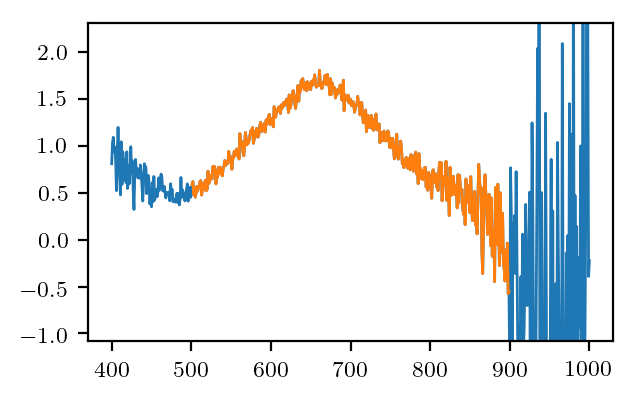

In [6]:
spectrum_idx_OI = np.argwhere(
    np.logical_and(
        disk_spec['spec'].T[0]<900,
        disk_spec['spec'].T[0]>500)
        )
fig_kwargs = {'lw':1}
plt.plot(*disk_spec['spec'].T, **fig_kwargs)
plt.plot(*disk_spec['spec'].T[:, spectrum_idx_OI], **fig_kwargs)
plt.ylim(
    np.min(disk_spec['spec'].T[1, spectrum_idx_OI])-.5,
    np.max(disk_spec['spec'].T[1, spectrum_idx_OI])+.5,
    )
    

In [7]:
## DEFINE BACKGROUND FOR FITS
eps_water = 1.778 ## approximately water. 
# eps_b=2

In [8]:
1.4**2

1.9599999999999997

In [9]:
hbarws = 1240/disk_spec['spec'].T[0, spectrum_idx_OI]
oblate_spec_data = disk_spec['spec'].T[1, spectrum_idx_OI]

## ----

def ret_fit_scat_1(hbarw, eps_inf, hbarw_p, hbargamma, height, diameter, eps_b=None):
    
    if eps_b is None:
        eps_b = eps_water
        
#     print(f'eps_b = {eps_b}')
    
    a_x = height / 2
    a_yz = diameter / 2
    
    return cd.long_sigma_scat_ret_pro_ellip(
        w=hbarw/hbar, 
        eps_inf=eps_inf, 
        w_p=hbarw_p/hbar, 
        gamma=hbargamma/hbar, 
        eps_b=eps_b, 
        a_x=a_x*m_per_nm, 
        a_yz=a_yz*m_per_nm)

#+++++++++++++++++++++++++++++++++++++++++++++
def oblate_cost_func(params, *args):
    x=args[0]
    y=args[1]

    
#     eps_inf=params[0]
#     w_p=params[1]
#     gamma=params[2]
#     a_x = params[3]
#     a_yz = params[4]
    
    y_normed = y/y.max()
    yfit_normed = oblate_fit_result(x, params)

    low_energy_forgiveness = np.ones(x.shape) - (x<1.6) * .1
    return (y_normed-yfit_normed).ravel()*low_energy_forgiveness.ravel()

def oblate_fit_result(x, params):
    
    amp = params[-1]
    phys_params = params[:-1]
    
    yfit=ret_fit_scat_1(x, *phys_params)
    
    return yfit/yfit.max() * amp

In [10]:
    
    #+++++++++++++++++++++++++++++++++++++++++++++
    ini_guess_both=np.array([3.48260965,  6.72763066,  0.65709936, 29.24119972, 79.24119972, .9])
    # ini_guess_both=np.array([11.6817827 ,  9.56022562,  0.8554153, 30.24119972, 80.24119972, .9])
    # ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
    params0=ini_guess_both   #parameter guess

    args=[hbarws, oblate_spec_data,]
    # for c in Ts:
    #   args.append(c) 
    args=tuple(args)   #doesn't work if args is a list!!

    result=opt.least_squares(
        oblate_cost_func, 
        params0, 
        ftol=1e-15,
        xtol=1e-15, 
        gtol=1e-15, 
        args=args,
#         bounds=(
#             [0,   0,  0,  20,  60, 0.75],
#             [18, 20, 1,  31,  80, 1.25],
#             ),
        x_scale=[1,1,1E-1,10, 10, 1],
        )

    #+++++++++++++++++++++++++++++++++++++++++++++
    fit_result = oblate_fit_result(hbarws, result['x'])
    # norm_fit_result = fit_result/fit_result.max()

    # higher_damp = result['x'].copy()
    # higher_damp[2] = 0.22
    # higher_damp[3] = 44

    # high_damp_result = ret_fit_scat_1(hbarws, *higher_damp)



In [11]:
fit_params = result['x']

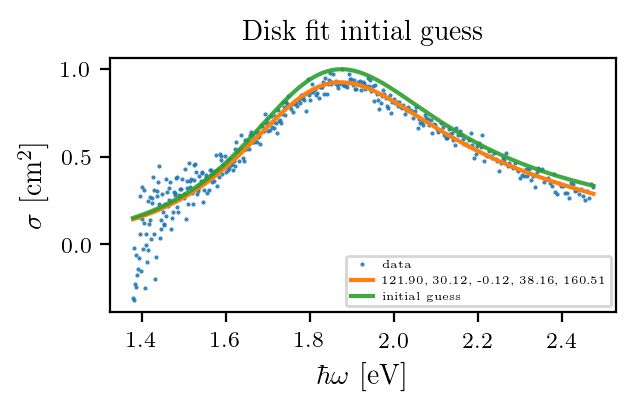

In [12]:
# plt.figure(dpi=100)
norm_data = oblate_spec_data/oblate_spec_data.max()

plt.plot(hbarws, norm_data, label='data', ls=' ', marker='.', markersize=1, alpha=.9)
# plt.plot(hbarws, ret_fit_scat_1(hbarws, *ini_guess_both),label='initial', ls='--')
# plt.plot(hbarws, 0.9*high_damp_result/high_damp_result.max(),label='test', ls='-')

plt.plot(hbarws, fit_result,label=f'{fit_params[0]:.2f}, {fit_params[1]:.2f}, {fit_params[2]:.2f}, {fit_params[3]:.2f}, {fit_params[4]:.2f}', ls='-')
# plt.plot(hbarws, oblate_cost_func(ini_guess_both, *args), label='initial cost func',
#         ls=' ', marker='.', markersize=1, alpha=.9)

ini_guess = ret_fit_scat_1(
    hbarws, 
    ini_guess_both[0], 
    ini_guess_both[1], 
    ini_guess_both[2], 
    ini_guess_both[3], 
    ini_guess_both[4])
plt.plot(
    hbarws, 
    ini_guess/ini_guess.max(), 
    label='initial guess',
#     ls=' ', 
#     marker='.', 
    markersize=1, 
    alpha=.9)

# plt.xlim([np.min(long_hbarws),np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Disk fit initial guess ')
plt.legend(fontsize=4)

# plt.figure(dpi=100)
# plt.plot(trans_hbarws, trans_sigma, label='data', ls=' ', marker='.')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *ini_guess_both), label='initial', ls='--')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *result['x'])*1e-10, label='result', ls='-')
# plt.xlim([np.min(long_hbarws), np.max(trans_hbarws)])
# plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.ylabel(r'$\sigma$ [cm$^2$]')
# plt.title(r'Transverse Mode Fit')
# plt.legend()
plt.tight_layout()

# Try fixing gold parameters and fitting background and geometry

In [13]:
#+++++++++++++++++++++++++++++++++++++++++++++
def fixed_gold_oblate__cost_func(params, *args):
    x=args[0]
    y=args[1]
    
    y_normed = y/y.max()
    yfit_normed = fixed_gold__oblate_fit_result(x, params)

    low_energy_forgiveness = np.ones(x.shape) - (x<1.6) * .1
    return (y_normed-yfit_normed).ravel()*low_energy_forgiveness.ravel()

def fixed_gold__oblate_fit_result(x, params):
    eps_b = params[0] 
    height = params[1]
    diameter = params[2]
    amp = params[3]
    ## fixed params (from nrod paper)
    eps_inf = 28.9857
    hwp = 13.5885
    hgam = 0.0977
    amp = params[-1]
    phys_params = params[:-1]
    
    yfit=ret_fit_scat_1(
        hbarw=x, 
        eps_inf=eps_inf, 
        hbarw_p=hwp, 
        hbargamma=hgam, 
        height=height, 
        diameter=diameter, 
        eps_b=eps_b)
    
    return yfit/yfit.max() * amp

In [14]:
    
#+++++++++++++++++++++++++++++++++++++++++++++
ini_guess__fized_gold = np.array([1.5,  40.17293345, 80.17293339,  0.94467404])
# ini_guess__fized_gold=np.array([11.6817827 ,  9.56022562,  0.8554153, 30.24119972, 80.24119972, .9])
# ini_guess__fized_gold=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0 = ini_guess__fized_gold   #parameter guess

args=[hbarws, oblate_spec_data,]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    fixed_gold_oblate__cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
#         bounds=(
#             [0,   0,  0,  20,  60, 0.75],
#             [18, 20, 1,  31,  80, 1.25],
#             ),
    x_scale=[.1, 30, 80, 1],
    )

#+++++++++++++++++++++++++++++++++++++++++++++
fit_params__fixed_gold = result['x']
fit_result = fixed_gold__oblate_fit_result(hbarws, fit_params__fixed_gold)

In [15]:
fit_params__fixed_gold

array([  1.41427021, 150.6003619 , 150.60035962,   0.93236707])

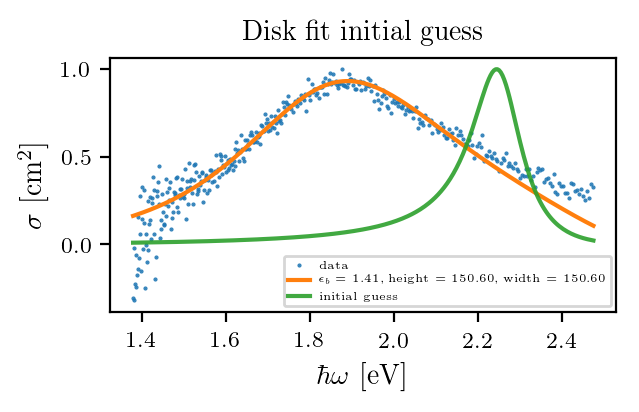

In [16]:
# plt.figure(dpi=100)
norm_data = oblate_spec_data/oblate_spec_data.max()

plt.plot(hbarws, norm_data, label='data', ls=' ', marker='.', markersize=1, alpha=.9)
# plt.plot(hbarws, ret_fit_scat_1(hbarws, *ini_guess_both),label='initial', ls='--')
# plt.plot(hbarws, 0.9*high_damp_result/high_damp_result.max(),label='test', ls='-')

plt.plot(hbarws, fit_result, label=r'$\epsilon_b=$ '+f'{fit_params__fixed_gold[0]:.2f}, height = {fit_params__fixed_gold[1]:.2f}, width = {fit_params__fixed_gold[2]:.2f}', ls='-')

ini_guess = fixed_gold__oblate_fit_result(
    hbarws, 
    ini_guess__fized_gold)
plt.plot(
    hbarws, 
    ini_guess/ini_guess.max(), 
    label='initial guess',
#     ls=' ', 
#     marker='.', 
    markersize=1, 
    alpha=.9)

# plt.xlim([np.min(long_hbarws),np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Disk fit initial guess ')
plt.legend(fontsize=4)

# plt.figure(dpi=100)
# plt.plot(trans_hbarws, trans_sigma, label='data', ls=' ', marker='.')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *ini_guess_both), label='initial', ls='--')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *result['x'])*1e-10, label='result', ls='-')
# plt.xlim([np.min(long_hbarws), np.max(trans_hbarws)])
# plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.ylabel(r'$\sigma$ [cm$^2$]')
# plt.title(r'Transverse Mode Fit')
# plt.legend()
plt.tight_layout()

## Try fitting 3 disks from Curly's thesis simultaneously
I can treat the thickness as a common parameter, as well as the background index.  

First load the data, and I think I need to sort the point for some reason.

In [41]:
diskrip_70nm = np.loadtxt("modeling_experiment/ripped_data/70 nm disk.csv", delimiter=',')
diskrip_76nm = np.loadtxt("modeling_experiment/ripped_data/76 nm disk.csv", delimiter=',')
diskrip_86nm = np.loadtxt("modeling_experiment/ripped_data/86 nm disk.csv", delimiter=',')

In [42]:
diskrip_70nm = diskrip_70nm[np.argsort(diskrip_70nm[:, 0])]
diskrip_76nm = diskrip_76nm[np.argsort(diskrip_76nm[:, 0])]
diskrip_86nm = diskrip_86nm[np.argsort(diskrip_86nm[:, 0])]

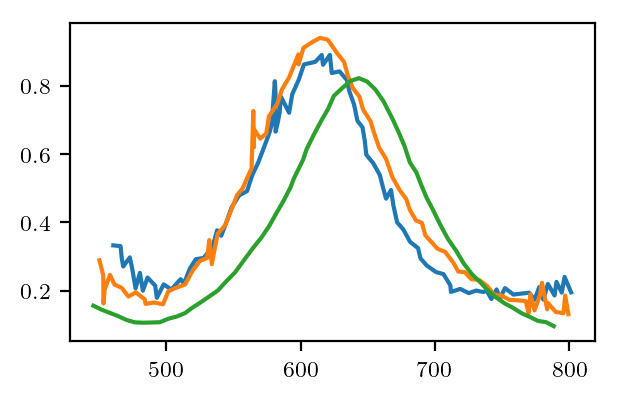

In [43]:
plt.plot(*diskrip_70nm.T)
plt.plot(*diskrip_76nm.T)
plt.plot(*diskrip_86nm.T)

Not sure why these got shifted, but the spike on the left side of the peaks should be aligned. 

In [37]:
shift_76 = diskrip_70nm[:,0].min() - diskrip_76nm[:,0].min()

In [38]:
shift_86 = diskrip_70nm[:,0].min() - diskrip_86nm[:,0].min()

In [44]:
diskrip_76nm[:, 0] += shift_76
diskrip_86nm[:, 0] += shift_86

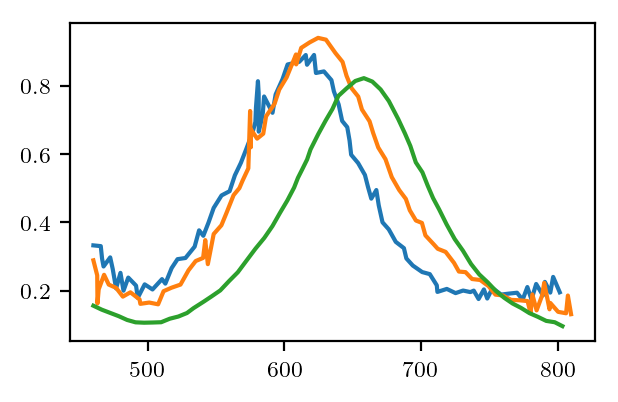

In [45]:
plt.plot(*diskrip_70nm.T)
plt.plot(*diskrip_76nm.T)
plt.plot(*diskrip_86nm.T)

This still seems fucked, but I don't want to waist more time on this. I can always get the data later.

In [169]:
def test_func(**kwargs):
    if 'a' in kwargs:
        print(kwargs['a'])

In [170]:
test_func(a=1)

1


In [192]:
#+++++++++++++++++++++++++++++++++++++++++++++
def tipple_fit__cost_func(params, *args, **kwargs):
    """ Eneter data in expanded form:
        *args = [x_70, y_70, x_76, ... ]
        """
    ## ~~~~~~~~
    ## energies
    x_70 = args[0]
    x_76 = args[2]
    x_86 = args[4]
    ## Datas
    y_70 = args[1]
    y_76 = args[3]
    y_86 = args[5]
    
    ## Get model spectra
    disk_70, disk_76, disk_86 = disk_specs_from_params(params, x_70, x_76, x_86)
    
    if 'cuttoff' in kwargs:
        cuttoff = kwargs['cuttoff']
    else:
        cuttoff = 520
        
    if 'stretch_model' in kwargs:
        if kwargs['stretch_model']:

            disk_70 = (disk_70 - disk_70.min())
            disk_70 /= disk_70.max()

            disk_76 = (disk_76 - disk_76.min())
            disk_76 /= disk_76.max()

            disk_86 = (disk_86 - disk_86.min())
            disk_86 /= disk_86.max()
        
    model__minus__data = np.concatenate((
        (
            (disk_70 - y_70)
            *(1240/x_70>cuttoff)
            ), 
        (
            (disk_76 - y_76)
            *(1240/x_76>cuttoff)
            ), 
        (
            (disk_86 - y_86)
            *(1240/x_86>cuttoff)
            )))    
    
    
    return (model__minus__data).ravel()


def disk_specs_from_params(params, x_70, x_76=None, x_86=None):
    ## Params are 
    ## params[0] : common eps_b
    ## params[1] : common height
    ## params[2] : diameter 1
    ## params[3] : diameter 2
    ## params[4] : diameter 3
    ## params[5] : amp 1
    ## params[6] : amp 2
    ## params[7] : amp 3
    params_70 = [*params[0:2], params[2], params[5],]
    params_76 = [*params[0:2], params[3], params[6],]
    params_86 = [*params[0:2], params[4], params[7],]
    
    disk_70 = fixed_gold__oblate_fit_result(x_70, params_70)
    disk_76 = fixed_gold__oblate_fit_result(x_76, params_76)
    disk_86 = fixed_gold__oblate_fit_result(x_86, params_86)
    
    return disk_70, disk_76, disk_86


def fixed_gold__oblate_fit_result(x, params):
    eps_b = params[0] 
    height = params[1]
    diameter = params[2]
    amp = params[3]
    ## fixed params (from nrod paper)
    eps_inf = 28.9857
    hwp = 13.5885
    hgam = 0.0977
    amp = params[-1]
    phys_params = params[:-1]
    
    yfit=ret_fit_scat_1(
        hbarw=x, 
        eps_inf=eps_inf, 
        hbarw_p=hwp, 
        hbargamma=hgam, 
        height=height, 
        diameter=diameter, 
        eps_b=eps_b)
    
    return yfit/yfit.max() * amp

In [182]:
    
#+++++++++++++++++++++++++++++++++++++++++++++
params0 =  np.array([1.4**2,  30.17293345, 70, 76, 86,  0.94467404, 0.94467404, 0.94467404])

args = (
    1240/diskrip_70nm.T[0], 
    diskrip_70nm.T[1],
    1240/diskrip_76nm.T[0], 
    diskrip_76nm.T[1],
    1240/diskrip_86nm.T[0], 
    diskrip_86nm.T[1],)

result = opt.least_squares(
    tipple_fit__cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
        bounds=(
            [1.33**2, 20, 60, 60, 60, .8, .8, .8],
            [1.5**2, 40, 150, 150, 150, 1, 1, 1],
            ),
    x_scale=[.1, 30, 80, 80, 80, 1, 1, 1],
    )

#+++++++++++++++++++++++++++++++++++++++++++++
tripple_fit__params = result['x']
(disk_70nm__fit_spec, disk_76nm__fit_spec, disk_86nm__fit_spec) = disk_specs_from_params(
    tripple_fit__params, 
    x_70=1240/diskrip_70nm.T[0], 
    x_76=1240/diskrip_76nm.T[0], 
    x_86=1240/diskrip_86nm.T[0],)

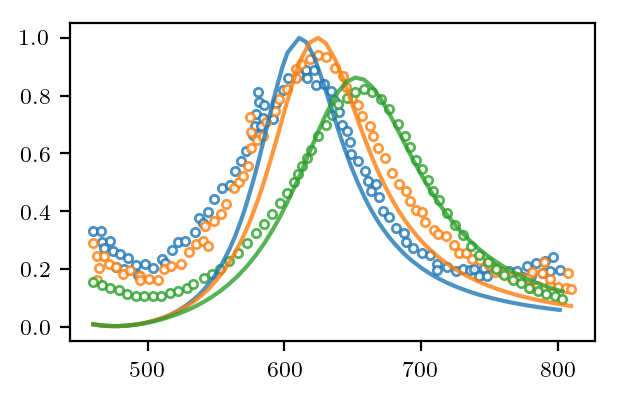

In [183]:
plt.plot(*diskrip_70nm.T, ls='', marker='o', markersize=3, markerfacecolor='w', alpha=.8)
plt.plot(*diskrip_76nm.T, ls='', marker='o', markersize=3, markerfacecolor='w', alpha=.8)
plt.plot(*diskrip_86nm.T, ls='', marker='o', markersize=3, markerfacecolor='w', alpha=.8)

plt.plot(diskrip_70nm.T[0], disk_70nm__fit_spec, alpha=.8, c='C0')
plt.plot(diskrip_76nm.T[0], disk_76nm__fit_spec, alpha=.8, c='C1')
plt.plot(diskrip_86nm.T[0], disk_86nm__fit_spec, alpha=.8, c='C2')

In [184]:
tripple_fit__params

array([  1.7689    ,  40.        , 107.41306406, 113.80999784,
       126.33548656,   1.        ,   1.        ,   0.86249872])

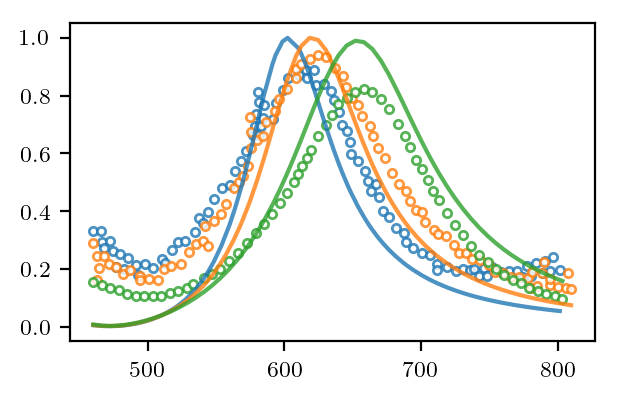

In [185]:
test_params = np.array([  
    2.2090167,  
    50 , 
    70*1.3, 
    76*1.3,
    86*1.3,   
    0.99999353,  
    0.99999998,   
    .99])

plt.plot(*diskrip_70nm.T, ls='', marker='o', markersize=3, markerfacecolor='w', alpha=.8)
plt.plot(*diskrip_76nm.T, ls='', marker='o', markersize=3, markerfacecolor='w', alpha=.8)
plt.plot(*diskrip_86nm.T, ls='', marker='o', markersize=3, markerfacecolor='w', alpha=.8)

(disk_70nm__fit_spec, disk_76nm__fit_spec, disk_86nm__fit_spec) = disk_specs_from_params(
    test_params, 
    x_70=1240/diskrip_70nm.T[0], 
    x_76=1240/diskrip_76nm.T[0], 
    x_86=1240/diskrip_86nm.T[0],)

plt.plot(diskrip_70nm.T[0], disk_70nm__fit_spec, alpha=.8, c='C0')
plt.plot(diskrip_76nm.T[0], disk_76nm__fit_spec, alpha=.8, c='C1')
plt.plot(diskrip_86nm.T[0], disk_86nm__fit_spec, alpha=.8, c='C2')

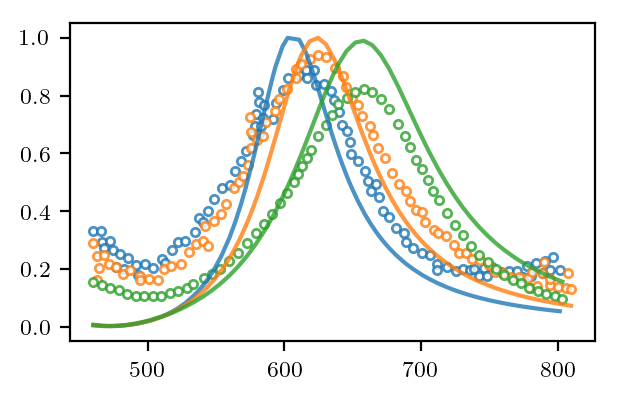

In [186]:
test_params = np.array([  
    2.2090167,  
    45.9999685 , 
    70*1.3, 
    76*1.3,
    86*1.3,   
    0.99999353,  
    0.99999998,   
    .99])

plt.plot(*diskrip_70nm.T, ls='', marker='o', markersize=3, markerfacecolor='w', alpha=.8)
plt.plot(*diskrip_76nm.T, ls='', marker='o', markersize=3, markerfacecolor='w', alpha=.8)
plt.plot(*diskrip_86nm.T, ls='', marker='o', markersize=3, markerfacecolor='w', alpha=.8)

(disk_70nm__fit_spec, disk_76nm__fit_spec, disk_86nm__fit_spec) = disk_specs_from_params(
    test_params, 
    x_70=1240/diskrip_70nm.T[0], 
    x_76=1240/diskrip_76nm.T[0], 
    x_86=1240/diskrip_86nm.T[0],)

plt.plot(diskrip_70nm.T[0], disk_70nm__fit_spec, alpha=.8, c='C0')
plt.plot(diskrip_76nm.T[0], disk_76nm__fit_spec, alpha=.8, c='C1')
plt.plot(diskrip_86nm.T[0], disk_86nm__fit_spec, alpha=.8, c='C2')

In [187]:
1.33**2

1.7689000000000001

In [188]:
1.5**2

2.25

### Try the fit with stretched data

In [193]:
#+++++++++++++++++++++++++++++++++++++++++++++
params0 =  np.array([1.4**2,  30.17293345, 70, 76, 86,  0.94467404, 0.94467404, 0.94467404])

args = (
    1240/diskrip_70nm.T[0], 
    stretched_diskrip_70nm_data,
    1240/diskrip_76nm.T[0], 
    stretched_diskrip_76nm_data,
    1240/diskrip_86nm.T[0], 
    stretched_diskrip_86nm_data,)

result = opt.least_squares(
    tipple_fit__cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    kwargs={'cuttoff':600, 'stretch_model':True},
        bounds=(
            [1.33**2, 20, 60, 60, 60, .8, .8, .8],
            [1.5**2, 40, 150, 150, 150, 1, 1, 1],
            ),
    x_scale=[.1, 30, 80, 80, 80, 1, 1, 1],
    )

#+++++++++++++++++++++++++++++++++++++++++++++
tripple_fit__params = result['x']
(disk_70nm__fit_spec, disk_76nm__fit_spec, disk_86nm__fit_spec) = disk_specs_from_params(
    tripple_fit__params, 
    x_70=1240/diskrip_70nm.T[0], 
    x_76=1240/diskrip_76nm.T[0], 
    x_86=1240/diskrip_86nm.T[0],)

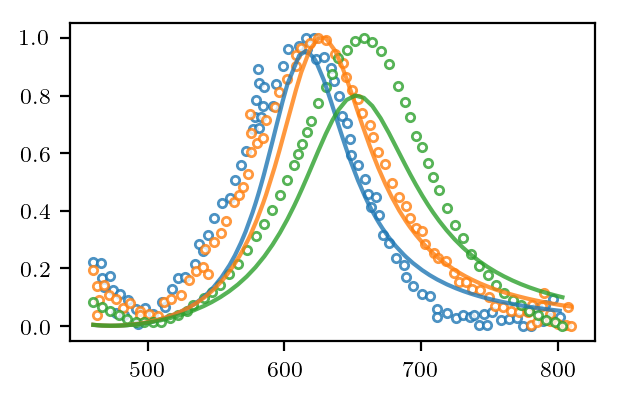

In [194]:
plt.plot(diskrip_70nm.T[0], stretched_diskrip_70nm_data, ls='', marker='o', markersize=3, markerfacecolor='w', alpha=.8)
plt.plot(diskrip_76nm.T[0], stretched_diskrip_76nm_data, ls='', marker='o', markersize=3, markerfacecolor='w', alpha=.8)
plt.plot(diskrip_86nm.T[0], stretched_diskrip_86nm_data, ls='', marker='o', markersize=3, markerfacecolor='w', alpha=.8)

plt.plot(diskrip_70nm.T[0], disk_70nm__fit_spec, alpha=.8, c='C0')
plt.plot(diskrip_76nm.T[0], disk_76nm__fit_spec, alpha=.8, c='C1')
plt.plot(diskrip_86nm.T[0], disk_86nm__fit_spec, alpha=.8, c='C2')

In [195]:
tripple_fit__params

array([  2.05097036,  38.64967512,  97.33985848, 102.76184902,
       113.17542785,   0.9542175 ,   0.99864626,   0.80000448])

In [ ]:
test_params

In [204]:
#+++++++++++++++++++++++++++++++++++++++++++++
params0 = test_params
params0[0] = 1.33**2

args = (
    1240/diskrip_70nm.T[0], 
    stretched_diskrip_70nm_data,
    1240/diskrip_76nm.T[0], 
    stretched_diskrip_76nm_data,
    1240/diskrip_86nm.T[0], 
    stretched_diskrip_86nm_data,)

result = opt.least_squares(
    tipple_fit__cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    kwargs={'cuttoff':600, 'stretch_model':True},
        bounds=(
            [1.33**2, 20, 60, 60, 60, .8, .8, .8],
            [1.5**2, 60, 150, 150, 150, 1, 1, 1],
            ),
    x_scale=[.1, 30, 80, 80, 80, 1, 1, 1],
    )

#+++++++++++++++++++++++++++++++++++++++++++++
tripple_fit__params = result['x']
(disk_70nm__fit_spec, disk_76nm__fit_spec, disk_86nm__fit_spec) = disk_specs_from_params(
    tripple_fit__params, 
    x_70=1240/diskrip_70nm.T[0], 
    x_76=1240/diskrip_76nm.T[0], 
    x_86=1240/diskrip_86nm.T[0],)

In [208]:
result['success']

True

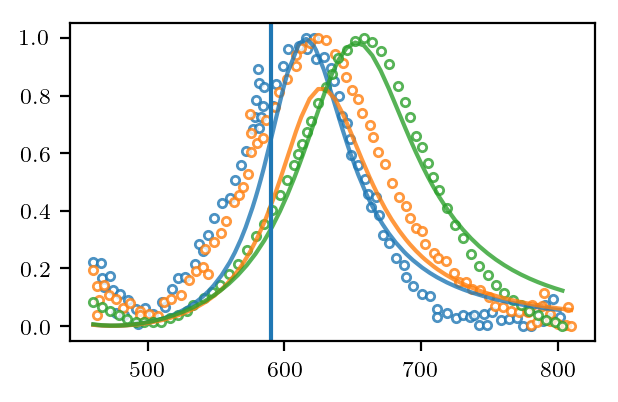

In [205]:
plt.plot(diskrip_70nm.T[0], stretched_diskrip_70nm_data, ls='', marker='o', markersize=3, markerfacecolor='w', alpha=.8)
plt.plot(diskrip_76nm.T[0], stretched_diskrip_76nm_data, ls='', marker='o', markersize=3, markerfacecolor='w', alpha=.8)
plt.plot(diskrip_86nm.T[0], stretched_diskrip_86nm_data, ls='', marker='o', markersize=3, markerfacecolor='w', alpha=.8)

plt.plot(diskrip_70nm.T[0], disk_70nm__fit_spec, alpha=.8, c='C0')
plt.plot(diskrip_76nm.T[0], disk_76nm__fit_spec, alpha=.8, c='C1')
plt.plot(diskrip_86nm.T[0], disk_86nm__fit_spec, alpha=.8, c='C2')

plt.axvline(590)

In [206]:
tripple_fit__params

array([  1.93277895,  37.55500977, 101.14308604, 106.74168273,
       117.41277877,   0.99609891,   0.82254921,   0.98380044])

In [207]:
1.93277**0.5

1.3902409863041731

In [214]:
117.41277877/2

58.706389385

In [209]:
37.55500977/2

18.777504885

In [200]:
97.83733599/2

48.918667995

In [201]:
107.85095189/2

53.925475945

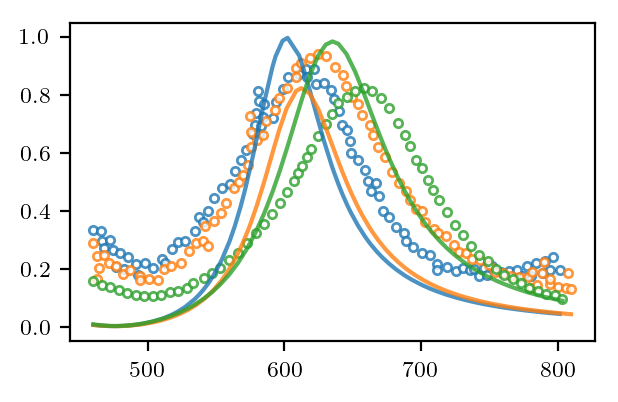

In [211]:
test_params = np.array([  1.33**2,  37.55500977, 101.14308604, 106.74168273,
       117.41277877,   0.99609891,   0.82254921,   0.98380044])

plt.plot(*diskrip_70nm.T, ls='', marker='o', markersize=3, markerfacecolor='w', alpha=.8)
plt.plot(*diskrip_76nm.T, ls='', marker='o', markersize=3, markerfacecolor='w', alpha=.8)
plt.plot(*diskrip_86nm.T, ls='', marker='o', markersize=3, markerfacecolor='w', alpha=.8)

(disk_70nm__fit_spec, disk_76nm__fit_spec, disk_86nm__fit_spec) = disk_specs_from_params(
    test_params, 
    x_70=1240/diskrip_70nm.T[0], 
    x_76=1240/diskrip_76nm.T[0], 
    x_86=1240/diskrip_86nm.T[0],)

plt.plot(diskrip_70nm.T[0], disk_70nm__fit_spec, alpha=.8, c='C0')
plt.plot(diskrip_76nm.T[0], disk_76nm__fit_spec, alpha=.8, c='C1')
plt.plot(diskrip_86nm.T[0], disk_86nm__fit_spec, alpha=.8, c='C2')

In [216]:
101.14308604/2

50.57154302

In [215]:
106.74/2

53.37

In [212]:
1.33**2


1.7689000000000001

# 